In [114]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model 
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# log = xes_importer.apply('filtered_log.xes')
# log = xes_importer.apply('financial_log-filtered-5.xes')
log = xes_importer.apply('data/BPI_Challenge_2018.xes')
# log = xes_importer.apply('SuncorpSkin.xes')


In [343]:
sizes_dict = {}

for i in range(len(log)):
    k = len(log[i])
    if k in sizes_dict:
        v = sizes_dict[k] 
        sizes_dict[k] = v + 1
    else:
        sizes_dict[k] = 1
print(sizes_dict)

{3: 3879, 6: 1872, 8: 868, 7: 377, 10: 149, 9: 64, 12: 33, 18: 78, 14: 32, 17: 52, 16: 61, 11: 17, 15: 23, 21: 55, 22: 49, 19: 54, 20: 53, 26: 31, 25: 15, 24: 46, 23: 56, 31: 14, 28: 7, 33: 11, 34: 5, 32: 10, 30: 5, 27: 5}


In [345]:
print('Number of actions: ', len(sizes_dict))
print('Number of examples: ', len(log))



Number of actions:  28
Number of examples:  7921


In [330]:
vocab_index = {}
input_sequences = []
for seq in log:
    sequence = []
    for action in seq:
        action_name = action['concept:name']
        if not action_name in vocab_index:
            v = len(vocab_index) + 1
            vocab_index[action_name] = v
        action_index = vocab_index[action_name]
        sequence.append(action_index)
    if len(sequence) != 0:
        for i in range(1, len(sequence)):
            input_sequences.append(sequence[:i+1])

total_words = len(vocab_index) + 1

In [331]:
sample = 20
reverse_vocab_index = dict(map(reversed, vocab_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_vocab_index[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[1, 2]
 and it corresponds to:
A_SUBMITTED A_PARTLYSUBMITTED 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [332]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [333]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_vocab_index:
        print(reverse_vocab_index[i], end=' ')
    else:
        print("__", end=' ')
print("]")


The entry  20  in 'input_sequences' is: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ A_SUBMITTED A_PARTLYSUBMITTED ]


Given a sentence like **"A B A C"**, we want to design a model that can predict the next action -- in the case the action **"C"**.

Therefore, the next code prepares our input and output to our model consequently.

In [334]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [335]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
, it corresponds to the following input to our model:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 and the following output:  2


In [336]:
# label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

<img src="imgs/text_generation.png" style="width:600;height:400px;">




 
**Exercise**: Implement `model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 33, 8)             184       
_________________________________________________________________
lstm_50 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_50 (Dense)             (None, 23)                759       
Total params: 6,191
Trainable params: 6,191
Non-trainable params: 0
_________________________________________________________________


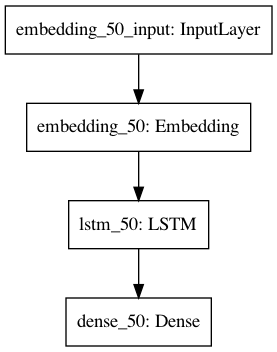

In [337]:
def create_model():
    model = Sequential()
    model.add(Embedding(total_words, 8, input_length=max_sequence_len-1))
    model.add(LSTM(32))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    return model
    
# #Print details of the model.
model = create_model()
model.summary()
plot_model(model)


In [338]:
model = create_model()
x = 10000

x_train = input_to_model[0:x]
y_train = label[0:x]

history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)


Epoch 1/10
157/157 [==============================] - 2s 13ms/step - loss: 1.4589 - accuracy: 0.5249
Epoch 2/10
157/157 [==============================] - 2s 12ms/step - loss: 0.7115 - accuracy: 0.8593
Epoch 3/10
157/157 [==============================] - 2s 11ms/step - loss: 0.3047 - accuracy: 0.9380
Epoch 4/10
157/157 [==============================] - 2s 12ms/step - loss: 0.2168 - accuracy: 0.9551
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1835 - accuracy: 0.9551
Epoch 6/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1677 - accuracy: 0.9551
Epoch 7/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1600 - accuracy: 0.9551
Epoch 8/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1558 - accuracy: 0.9551
Epoch 9/10
157/157 [==============================] - 2s 13ms/step - loss: 0.1531 - accuracy: 0.9551
Epoch 10/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1517 - accura

In [339]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(acc) + 1)

# plt.figure(figsize=(15,4))

# ax1 = plt.subplot(1, 2, 1)
# plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
# plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# ax2 = plt.subplot(1, 2, 2)
# plt.plot(epochs, acc, label='Training accuracy')
# plt.plot(epochs, val_acc, label='Validation accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

KeyError: 'val_accuracy'

In [340]:
test_set = []
step = 100
x = 10000

for i in range(0,1000000, step):
    if x+i+step > len(input_to_model):
            break
    x_test_1 = input_to_model[x+i:x+i+step] 
    y_test_1 = label[x+i:x+i+step] 
    test_set.append((x_test_1, y_test_1))
    
accuracy_list = []
for x_test,y_test in test_set:
    accuracy_list.append(model.evaluate(x_test,y_test, verbose=0)[1])

    


In [341]:
N = 50
cumsum, moving_aves = [0], []

for i, x in enumerate(accuracy_list, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

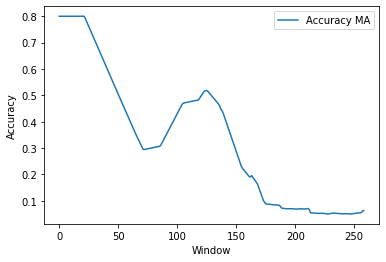

In [342]:
# plt.plot(list(range(len(accuracy_list))), accuracy_list, label='Accuracy')
plt.plot(list(range(len(moving_aves))), moving_aves, label='Accuracy MA')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
